In [1]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [2]:
import os
project_path = '/content/drive/My Drive/The School of AI'
os.chdir(project_path)

CODE BLOCK 1

In [3]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torchvision import datasets, transforms

CODE BLOCK 2

In [4]:
# CUDA?
cuda = torch.cuda.is_available()
print("CUDA Available?", cuda)

CUDA Available? True


CODE BLOCK 3

In [5]:
# Train data transformations
train_transforms = transforms.Compose([
    transforms.RandomApply([transforms.CenterCrop(22), ], p=0.1),
    transforms.Resize((28, 28)),
    transforms.RandomRotation((-15., 15.), fill=0),
    transforms.ToTensor(),
    transforms.Normalize((0.1307,), (0.3081,)),
    ])

# Test data transformations
test_transforms = transforms.Compose([
    transforms.ToTensor(),
    #transforms.Normalize((0.1407,), (0.4081,))
    transforms.Normalize((0.1307,), (0.3081,))
    ])

CODE BLOCK 4

In [6]:
train_data = datasets.MNIST('../data', train=True, download=True, transform=train_transforms)
#test_data = datasets.MNIST('../data', train=True, download=True, transform=train_transforms)
test_data = datasets.MNIST('../data', train=False, download=True, transform=test_transforms)

In [7]:
type(train_data), len(train_data), len(train_data[0]), train_data.data.shape, test_data.data.shape

(torchvision.datasets.mnist.MNIST,
 60000,
 2,
 torch.Size([60000, 28, 28]),
 torch.Size([10000, 28, 28]))

CODE BLOCK 5

In [8]:
batch_size = 512

#kwargs = {'batch_size': batch_size, 'shuffle': False, 'num_workers': 2, 'pin_memory': True}
kwargs = {'batch_size': batch_size, 'shuffle': True, 'num_workers': 2, 'pin_memory': True}

#test_loader = torch.utils.data.DataLoader(train_data, **kwargs)
test_loader = torch.utils.data.DataLoader(test_data, **kwargs)
train_loader = torch.utils.data.DataLoader(train_data, **kwargs)

In [9]:
train_loader.dataset.train_data.shape, test_loader.dataset.test_data.shape

/usr/local/lib/python3.10/dist-packages/torchvision/datasets/mnist.py:75: UserWarning: train_data has been renamed data
  warnings.warn("train_data has been renamed data")
/usr/local/lib/python3.10/dist-packages/torchvision/datasets/mnist.py:80: UserWarning: test_data has been renamed data
  warnings.warn("test_data has been renamed data")


(torch.Size([60000, 28, 28]), torch.Size([10000, 28, 28]))

CODE BLOCK 6

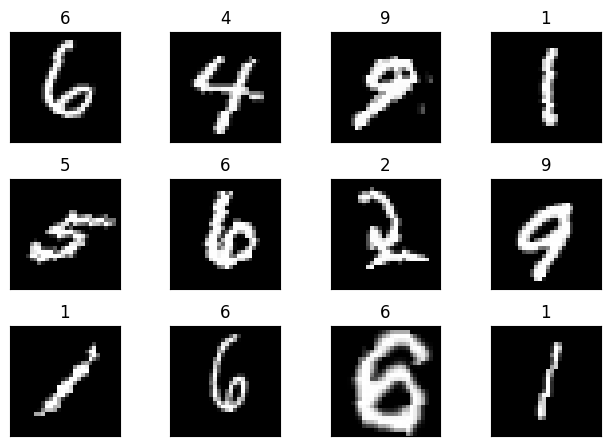

In [9]:
import matplotlib.pyplot as plt

batch_data, batch_label = next(iter(train_loader)) 

fig = plt.figure()

for i in range(12):
  plt.subplot(3,4,i+1)
  plt.tight_layout()
  plt.imshow(batch_data[i].squeeze(0), cmap='gray')
  plt.title(batch_label[i].item())
  plt.xticks([])
  plt.yticks([])

CODE BLOCK 7



1. image size : 28x28x1
2. Layer 1: Kernel: 3x3x1,32: output: 26x26x32:r_in:1, padding:0, Stride:1 r_out: (28+2*0-3)/1+1= 26: j_in:1, j_out: 1*1=1
3. Layer 2: Kernel: 3x3x32,64: output: 24x24x64, r_in:26, padding:0, Stride:1 r_out: (26+2*0-3)/1+1= 24: j_in:1, j_out: 1*1=1
4. Max pool1: Kernel: 2x2x64,64: output: 12x12x64, r_in:24, padding:0, Stride:2 r_out: (24+2*0-3)/2+1= 12: j_in:1, j_out: 1*2=2
5. Layer 3: Kernel: 3x3x64,128: output: 10x10x128, r_in:12, padding:0, Stride:1 r_out: (12+2*0-3)/1+1= 10: j_in:2, j_out: 2*1=2
6. Layer 4: Kernel: 3x3x128,256: output: 8x8x256, r_in:10, padding:0, Stride:1 r_out: (10+2*0-3)/1+1= 8: j_in:2, j_out: 2*1=2
7. Max pool2: Kernel: 2x2x256,256: output: 4x4x256, r_in:10, padding:0, Stride:2 r_out: (10+2*0-3)/2+1= 4: j_in:2, j_out: 2*2=4
8. Total paramters in Kernel: 4096: Flatten to get 50 output channels
9. flatten to get 10 output classes from 50







In [10]:
class Net(nn.Module):
    #This defines the structure of the NN.
    def __init__(self): # i have increased (doubled) the number of parameters
        super(Net, self).__init__()
        self.conv1 = nn.Conv2d(1, 32, kernel_size=3) # 26*26*32
        self.conv2 = nn.Conv2d(32, 64, kernel_size=3) # 24*24*64 | 12*12*64
        self.conv3 = nn.Conv2d(64, 128, kernel_size=3) # 10*10*128
        self.conv4 = nn.Conv2d(128, 256, kernel_size=3) # 8*8*256 | 4*4*256
        #self.fc1 = nn.Linear(320, 50)
        self.fc1 = nn.Linear(4096, 50)
        self.fc2 = nn.Linear(50, 10)

    def forward(self, x):
        x = F.relu(self.conv1(x),2)
        #print("size after 1st layer: " ,x.shape)
        x = F.relu(F.max_pool2d(self.conv2(x), 2))
        #print("size after 2nd layer and max pooling: " ,x.shape)
        x = F.relu(self.conv3(x), 2)
        #print("size after 3rd layer: " ,x.shape)
        x = F.relu(F.max_pool2d(self.conv4(x), 2)) 
        #print("size after 4th layer and max pooling: " ,x.shape)
        #x = x.view(-1, 320)
        x = x.view(-1, 4096)
        x = F.relu(self.fc1(x))
        x = self.fc2(x)
        return F.log_softmax(x, dim=1)

CODE BLOCK 8

In [11]:
# Data to plot accuracy and loss graphs
train_losses = []
test_losses = []
train_acc = []
test_acc = []

test_incorrect_pred = {'images': [], 'ground_truths': [], 'predicted_vals': []}

CODE BLOCK 9

In [12]:
from tqdm import tqdm

def GetCorrectPredCount(pPrediction, pLabels):
  return pPrediction.argmax(dim=1).eq(pLabels).sum().item()

def train(model, device, train_loader, optimizer):
  model.train()
  pbar = tqdm(train_loader)

  train_loss = 0
  correct = 0
  processed = 0

  for batch_idx, (data, target) in enumerate(pbar):
    data, target = data.to(device), target.to(device)
    optimizer.zero_grad()

    # Predict
    pred = model(data)

    # Calculate loss
    loss = F.nll_loss(pred, target)
    train_loss+=loss.item()

    # Backpropagation
    loss.backward()
    optimizer.step()
    
    correct += GetCorrectPredCount(pred, target)
    processed += len(data)

    pbar.set_description(desc= f'Train: Loss={loss.item():0.4f} Batch_id={batch_idx} Accuracy={100*correct/processed:0.2f}')

  train_acc.append(100*correct/processed)
  train_losses.append(train_loss/len(train_loader))

def test(model, device, test_loader):
    model.eval()

    test_loss = 0
    correct = 0

    with torch.no_grad():
        for batch_idx, (data, target) in enumerate(test_loader):
            data, target = data.to(device), target.to(device)

            output = model(data)
            test_loss += F.nll_loss(output, target, reduction='sum').item()  # sum up batch loss

            correct += GetCorrectPredCount(output, target)


    test_loss /= len(test_loader.dataset)
    test_acc.append(100. * correct / len(test_loader.dataset))
    test_losses.append(test_loss)

    print('Test set: Average loss: {:.4f}, Accuracy: {}/{} ({:.2f}%)\n'.format(
        test_loss, correct, len(test_loader.dataset),
        100. * correct / len(test_loader.dataset)))

In [13]:
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
device

device(type='cuda', index=0)

In [14]:
!pip install torchsummary
from torchsummary import summary

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


1. Conv2d-1: kernel: 3x3x1,32 : No. of parameters: 288+32 bias = 320
2. Conv2d-2: kernel: 3x3x32,64 : No. of parameters: 18432+64 bias = 18496
3. Conv2d-3: kernel: 3x3x64,128 : No. of parameters: 73728+128 bias = 73,856
4. Conv2d-4: kernel: 3x3x128,256 : No. of parameters: 2,94,912+256 bias = 2,95,168
5. Linear -5: 4096*50 + 50 bias = 204,850
6. Linear -6: 50*10+10 bias = 510

In [15]:
model = Net().to(device)
summary(model, input_size=(1, 28, 28))

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1           [-1, 32, 26, 26]             320
            Conv2d-2           [-1, 64, 24, 24]          18,496
            Conv2d-3          [-1, 128, 10, 10]          73,856
            Conv2d-4            [-1, 256, 8, 8]         295,168
            Linear-5                   [-1, 50]         204,850
            Linear-6                   [-1, 10]             510
Total params: 593,200
Trainable params: 593,200
Non-trainable params: 0
----------------------------------------------------------------
Input size (MB): 0.00
Forward/backward pass size (MB): 0.67
Params size (MB): 2.26
Estimated Total Size (MB): 2.94
----------------------------------------------------------------


CODE BLOCK 10

In [16]:
model = Net().to(device)
#optimizer = optim.SGD(model.parameters(), lr=10.01, momentum=0.9)
optimizer = optim.SGD(model.parameters(), lr=0.01, momentum=0.9)
scheduler = optim.lr_scheduler.StepLR(optimizer, step_size=15, gamma=0.1, verbose=True)
#scheduler = optim.lr_scheduler.StepLR(optimizer, step_size=4, gamma=0.1, verbose=True)
num_epochs = 20

for epoch in range(1, num_epochs+1):
  print(f'Epoch {epoch}')
  train(model, device, train_loader, optimizer)
  #test(model, device, train_loader)
  test(model, device, test_loader)
  scheduler.step()

Adjusting learning rate of group 0 to 1.0000e-02.
Epoch 1


Train: Loss=1.9907 Batch_id=117 Accuracy=26.72: 100%|██████████| 118/118 [00:37<00:00,  3.19it/s]


Test set: Average loss: 1.9184, Accuracy: 4526/10000 (45.26%)

Adjusting learning rate of group 0 to 1.0000e-02.
Epoch 2


Train: Loss=0.2176 Batch_id=117 Accuracy=82.91: 100%|██████████| 118/118 [00:25<00:00,  4.55it/s]


Test set: Average loss: 0.1499, Accuracy: 9539/10000 (95.39%)

Adjusting learning rate of group 0 to 1.0000e-02.
Epoch 3


Train: Loss=0.2758 Batch_id=117 Accuracy=94.69: 100%|██████████| 118/118 [00:26<00:00,  4.53it/s]


Test set: Average loss: 0.0909, Accuracy: 9719/10000 (97.19%)

Adjusting learning rate of group 0 to 1.0000e-02.
Epoch 4


Train: Loss=0.1368 Batch_id=117 Accuracy=96.15: 100%|██████████| 118/118 [00:27<00:00,  4.28it/s]


Test set: Average loss: 0.0730, Accuracy: 9770/10000 (97.70%)

Adjusting learning rate of group 0 to 1.0000e-02.
Epoch 5


Train: Loss=0.1718 Batch_id=117 Accuracy=96.95: 100%|██████████| 118/118 [00:27<00:00,  4.24it/s]


Test set: Average loss: 0.0535, Accuracy: 9817/10000 (98.17%)

Adjusting learning rate of group 0 to 1.0000e-02.
Epoch 6


Train: Loss=0.0712 Batch_id=117 Accuracy=97.27: 100%|██████████| 118/118 [00:25<00:00,  4.63it/s]


Test set: Average loss: 0.0429, Accuracy: 9870/10000 (98.70%)

Adjusting learning rate of group 0 to 1.0000e-02.
Epoch 7


Train: Loss=0.0543 Batch_id=117 Accuracy=97.62: 100%|██████████| 118/118 [00:24<00:00,  4.75it/s]


Test set: Average loss: 0.0371, Accuracy: 9881/10000 (98.81%)

Adjusting learning rate of group 0 to 1.0000e-02.
Epoch 8


Train: Loss=0.0717 Batch_id=117 Accuracy=97.79: 100%|██████████| 118/118 [00:24<00:00,  4.79it/s]


Test set: Average loss: 0.0369, Accuracy: 9878/10000 (98.78%)

Adjusting learning rate of group 0 to 1.0000e-02.
Epoch 9


Train: Loss=0.0249 Batch_id=117 Accuracy=98.03: 100%|██████████| 118/118 [00:24<00:00,  4.88it/s]


Test set: Average loss: 0.0319, Accuracy: 9887/10000 (98.87%)

Adjusting learning rate of group 0 to 1.0000e-02.
Epoch 10


Train: Loss=0.0200 Batch_id=117 Accuracy=98.17: 100%|██████████| 118/118 [00:24<00:00,  4.78it/s]


Test set: Average loss: 0.0373, Accuracy: 9875/10000 (98.75%)

Adjusting learning rate of group 0 to 1.0000e-02.
Epoch 11


Train: Loss=0.1948 Batch_id=117 Accuracy=98.36: 100%|██████████| 118/118 [00:27<00:00,  4.35it/s]


Test set: Average loss: 0.0294, Accuracy: 9902/10000 (99.02%)

Adjusting learning rate of group 0 to 1.0000e-02.
Epoch 12


Train: Loss=0.0209 Batch_id=117 Accuracy=98.39: 100%|██████████| 118/118 [00:24<00:00,  4.75it/s]


Test set: Average loss: 0.0342, Accuracy: 9880/10000 (98.80%)

Adjusting learning rate of group 0 to 1.0000e-02.
Epoch 13


Train: Loss=0.0571 Batch_id=117 Accuracy=98.53: 100%|██████████| 118/118 [00:25<00:00,  4.60it/s]


Test set: Average loss: 0.0344, Accuracy: 9891/10000 (98.91%)

Adjusting learning rate of group 0 to 1.0000e-02.
Epoch 14


Train: Loss=0.0114 Batch_id=117 Accuracy=98.56: 100%|██████████| 118/118 [00:25<00:00,  4.61it/s]


Test set: Average loss: 0.0302, Accuracy: 9893/10000 (98.93%)

Adjusting learning rate of group 0 to 1.0000e-02.
Epoch 15


Train: Loss=0.0569 Batch_id=117 Accuracy=98.69: 100%|██████████| 118/118 [00:25<00:00,  4.59it/s]


Test set: Average loss: 0.0247, Accuracy: 9905/10000 (99.05%)

Adjusting learning rate of group 0 to 1.0000e-03.
Epoch 16


Train: Loss=0.0078 Batch_id=117 Accuracy=98.90: 100%|██████████| 118/118 [00:26<00:00,  4.41it/s]


Test set: Average loss: 0.0220, Accuracy: 9915/10000 (99.15%)

Adjusting learning rate of group 0 to 1.0000e-03.
Epoch 17


Train: Loss=0.0263 Batch_id=117 Accuracy=98.98: 100%|██████████| 118/118 [00:26<00:00,  4.50it/s]


Test set: Average loss: 0.0216, Accuracy: 9920/10000 (99.20%)

Adjusting learning rate of group 0 to 1.0000e-03.
Epoch 18


Train: Loss=0.0053 Batch_id=117 Accuracy=99.04: 100%|██████████| 118/118 [00:26<00:00,  4.47it/s]


Test set: Average loss: 0.0212, Accuracy: 9926/10000 (99.26%)

Adjusting learning rate of group 0 to 1.0000e-03.
Epoch 19


Train: Loss=0.0275 Batch_id=117 Accuracy=98.98: 100%|██████████| 118/118 [00:26<00:00,  4.48it/s]


Test set: Average loss: 0.0215, Accuracy: 9919/10000 (99.19%)

Adjusting learning rate of group 0 to 1.0000e-03.
Epoch 20


Train: Loss=0.0159 Batch_id=117 Accuracy=99.00: 100%|██████████| 118/118 [00:26<00:00,  4.53it/s]


Test set: Average loss: 0.0202, Accuracy: 9930/10000 (99.30%)

Adjusting learning rate of group 0 to 1.0000e-03.


Text(0.5, 1.0, 'Test Accuracy')

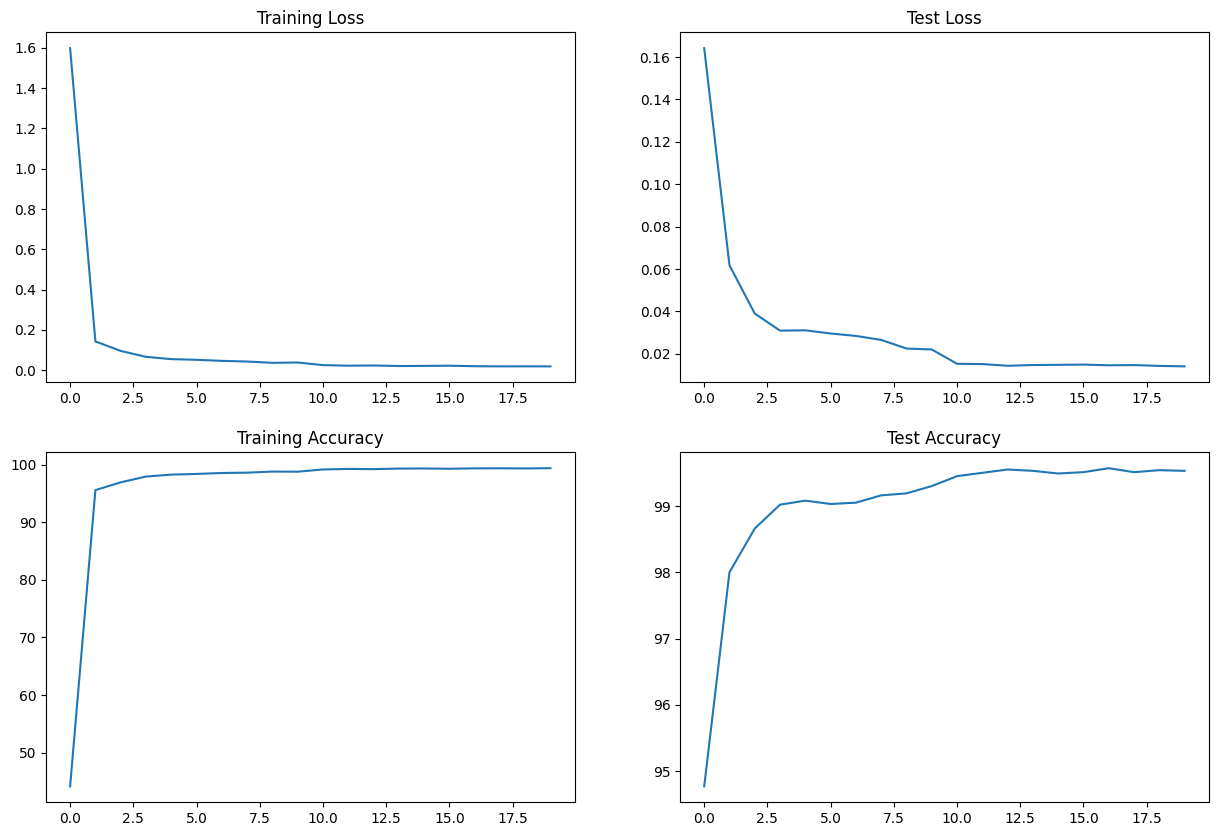

In [ ]:
fig, axs = plt.subplots(2,2,figsize=(15,10))
axs[0, 0].plot(train_losses)
axs[0, 0].set_title("Training Loss")
axs[1, 0].plot(train_acc)
axs[1, 0].set_title("Training Accuracy")
axs[0, 1].plot(test_losses)
axs[0, 1].set_title("Test Loss")
axs[1, 1].plot(test_acc)
axs[1, 1].set_title("Test Accuracy")

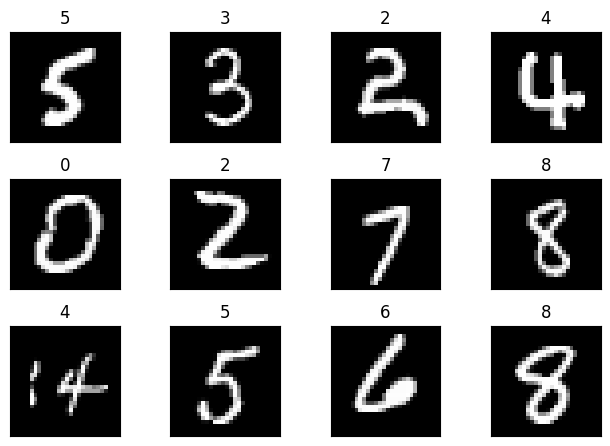

In [ ]:
# check prediction
batch_test_data, batch_test_label = next(iter(test_loader)) 

fig = plt.figure()

for i in range(12):
  plt.subplot(3,4,i+1)
  plt.tight_layout()
  plt.imshow(batch_test_data[i].squeeze(0), cmap='gray')
  plt.title(batch_test_label[i].item())
  plt.xticks([])
  plt.yticks([])
  #output = model(batch_test_data[i])
  #print("output: ",output)